In [93]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from Systems.HenonHeiles import *
from Systems.Generate_Data import *
from HamiltonianNeuralNetwork.pHNN import *
from NumericalIntegration.Numerical_Integration import *
from HamiltonianNeuralNetwork.Train import *
from HamiltonianNeuralNetwork.plotting import *
from HamiltonianNeuralNetwork.Training_Fourier_Basis import *


torch.random.manual_seed(1)
np.random.seed(33)
mps_device = torch.device("mps")

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [94]:
T_max_train = 6*np.pi
nsamples_train = int(100*T_max_train/6)
total_trajectories = 4000
ntraj_train = int(total_trajectories*0.7)
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = int(total_trajectories*0.3)
epochs = 100
epochs_Fourier = 200

batch_size = 64
lr = 1e-4

act_1 = PAU()
act_2 = nn.Softplus()

sys = HenonHeilesExternalForce()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [95]:
def H_loss_func(dudt,dudt_est):
    func = torch.nn.MSELoss()
    MSE_dudt = func(dudt_est,dudt)
    return MSE_dudt


def penalty_loss_func(model,time, lam_F=1e-4,lam_N=1e-4):
    penalty = 0
    penalty += lam_F*torch.mean(torch.abs(model.External_Force(time.reshape(-1,1)).detach()))
    penalty += lam_N*torch.mean(torch.abs(model.Get_N().detach()))

    return penalty

loss_func = loss_wrapper(H_loss_func)
penalty_func = loss_wrapper(penalty_loss_func)

In [96]:
def initial_condition(lam = 1):
    def sampler():
            """Function for sampling initial conditions. Callabale taking
                a numpy random generator as input and returning an ndarray
                of shape (nstates,) with inital conditions for the system."""
        
            x0= 0
            H0 = np.random.uniform(0,1/10)
            while True:
                y0 = np.random.uniform(-1,1)    
                py0 = np.random.uniform(-1,1)
                K = 2*H0-(py0**2 +y0**2-lam/3*y0**3)
                if K>= 0:
                    break
            px0 = np.sqrt(K)

            return np.array([x0,y0,px0,py0]).flatten()
    return sampler()
    
    

## Explicit Midpoint 

In [97]:
integrator = "midpoint"

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end,t_start, dt), dudt

(u_start, u_end,t_start, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, t_start, dt), dudt

  0%|          | 0/2800 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:09<00:00, 130.63it/s]


100%|██████████| 100/100 [2:36:00<00:00, 93.61s/it, epoch=99, loss=0.000157] 


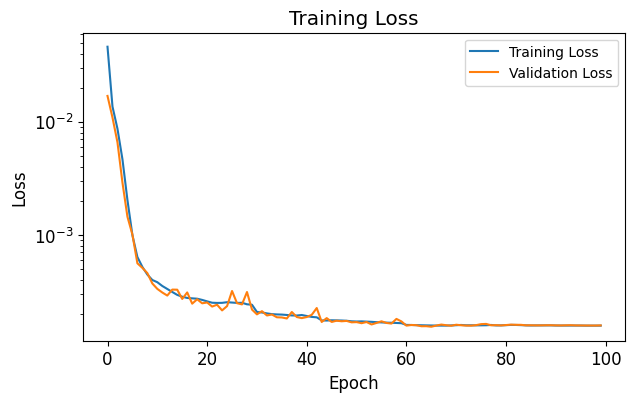

In [98]:
Hamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)
External_Forces_est = ExternalForceNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)


model_exp = PortHamiltonianNeuralNetwork(nstates = 4, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)

optimizer_exp = torch.optim.AdamW(model_exp.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_exp, factor=0.5, patience=5)


trainer = Training(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp, system = sys, batch_size=batch_size,epochs = epochs)
model_exp, trainingdetails_symp = trainer.train(loss_func=loss_func,penalty_func = penalty_func,scheduler=scheduler)


### Predicting from Explicit Midpoint - Training Interval

In [99]:
tmax = 6*np.pi
nsamples = int(100*tmax/6)
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_exp[0].detach().numpy()

100%|██████████| 1/1 [00:00<00:00, 56.59it/s]


/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/HamiltonianNeuralNetwork/pHNN.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)


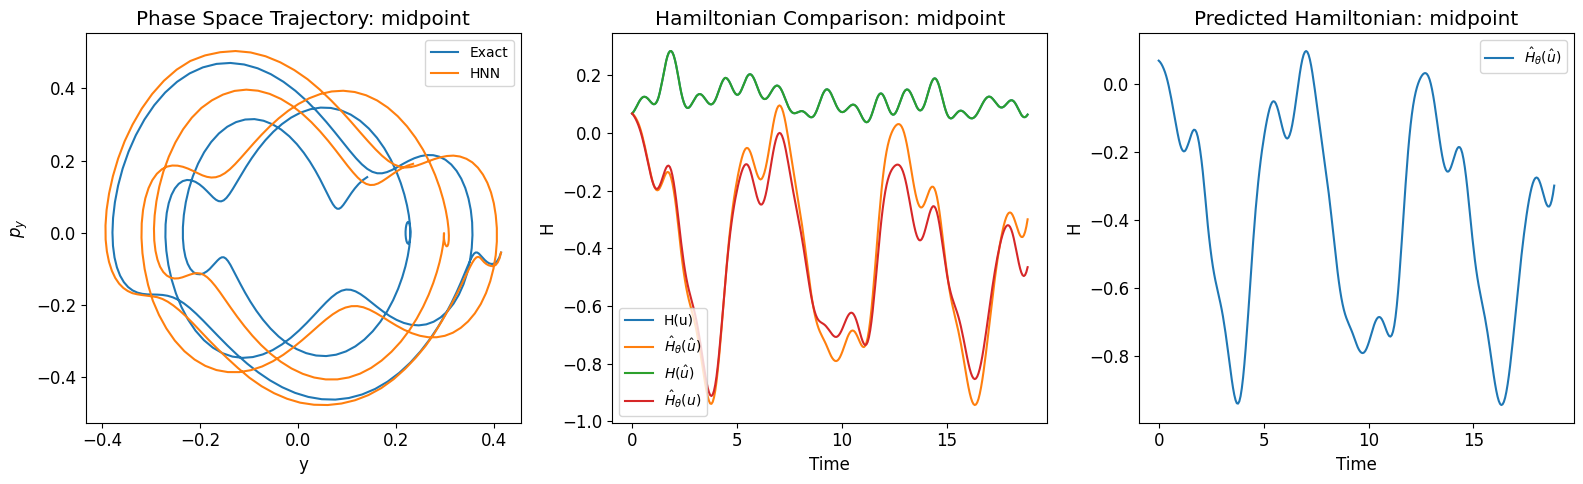

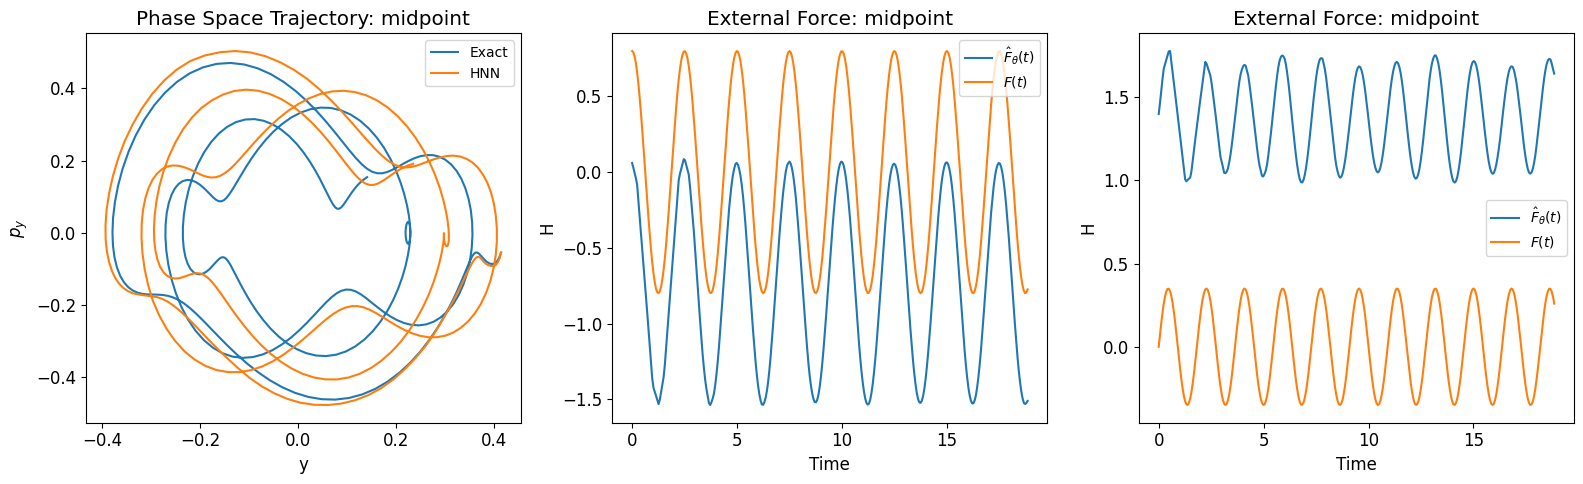

In [100]:
u0 = u0s
plot_PHNN_prediction(model_exp,u_pred,u_exact,t_sample,sys,u0,integrator)

In [101]:
true_diss = sys.get_dissipation()
true_diss

array([[-0.2 , -0.07]])

In [102]:
model_exp.Get_N()

Parameter containing:
tensor([[-0.1051, -0.0329]], requires_grad=True)

## Contour plot of the Hamiltonian

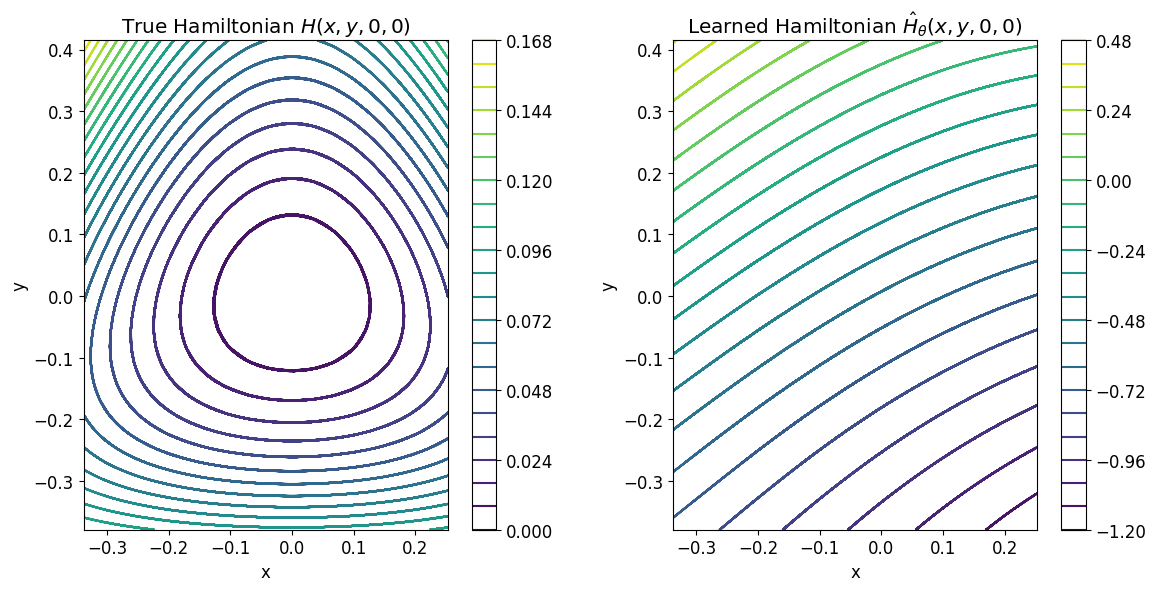

In [103]:
contour_plot_Hamiltonian(model_exp, sys, u_exact[0])

### Predicting from Explicit Midpoint - Longer Interval

In [104]:
tmax = 12*np.pi
nsamples = int(100*tmax/12)
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_exp[0].detach().numpy()


100%|██████████| 1/1 [00:00<00:00, 119.35it/s]


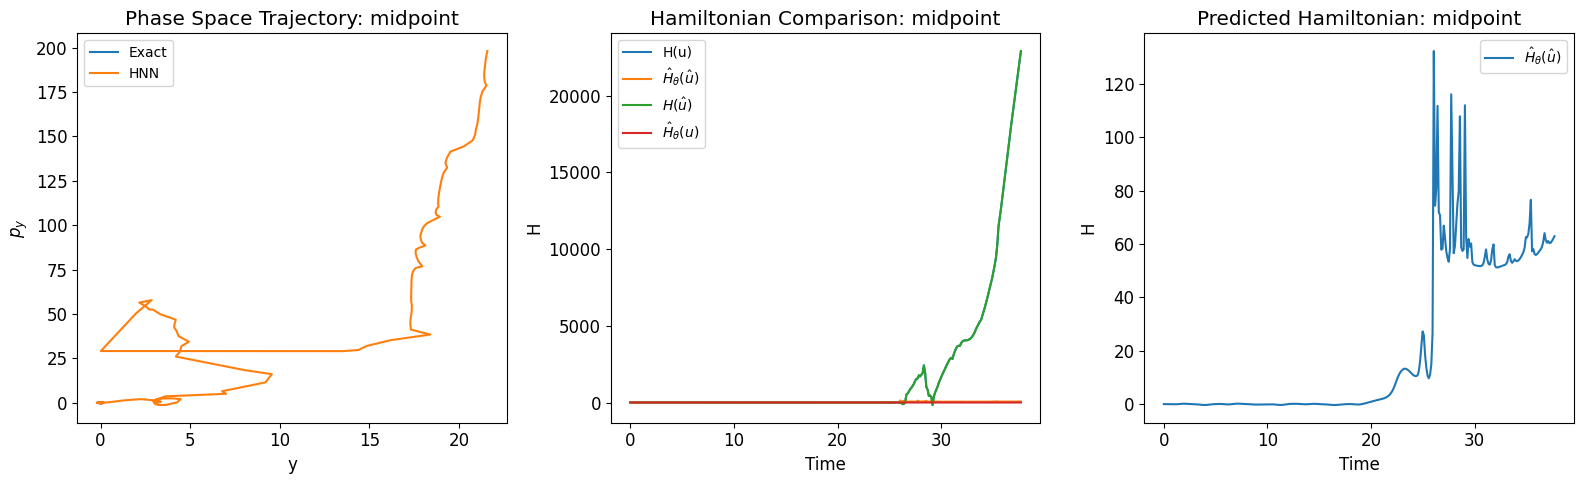

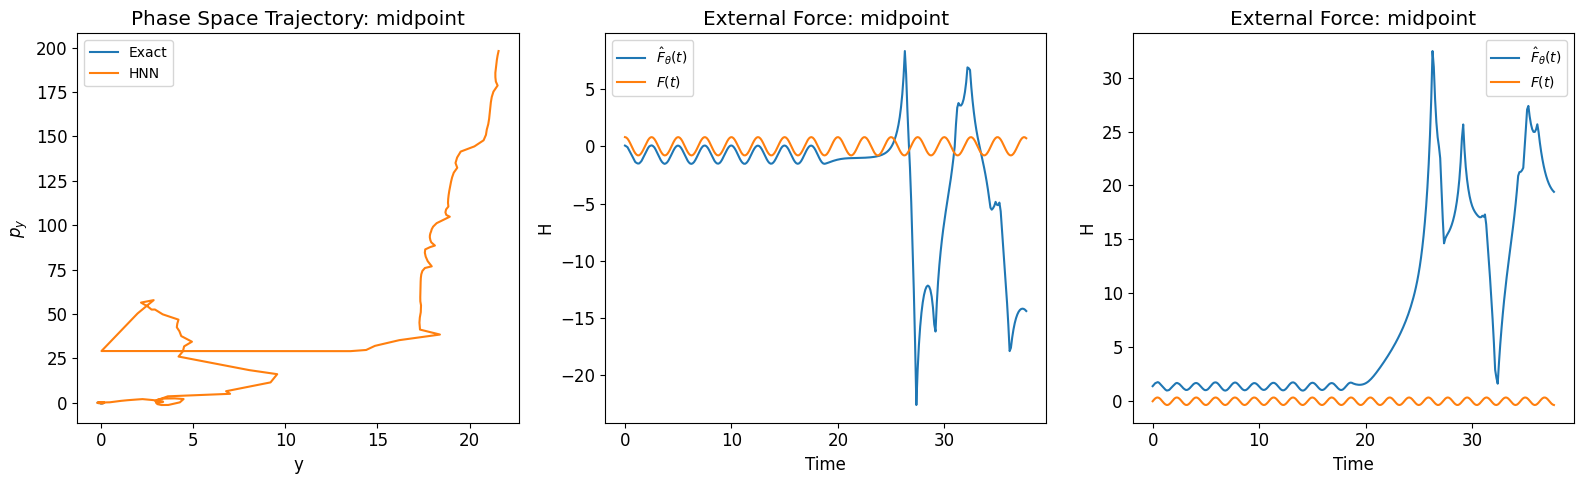

In [105]:
#plot_explicit(model_exp,u_pred,u_exact,t_sample)
u0 = u0s#plot_explicit(model_exp,u_pred,u_exact,t_sample)
plot_PHNN_prediction(model_exp,u_pred,u_exact,t_sample,sys,u0,integrator)

In [106]:
true_diss = sys.get_dissipation()
true_diss

array([[-0.2 , -0.07]])

In [107]:
model_exp.Get_N()

Parameter containing:
tensor([[-0.1051, -0.0329]], requires_grad=True)

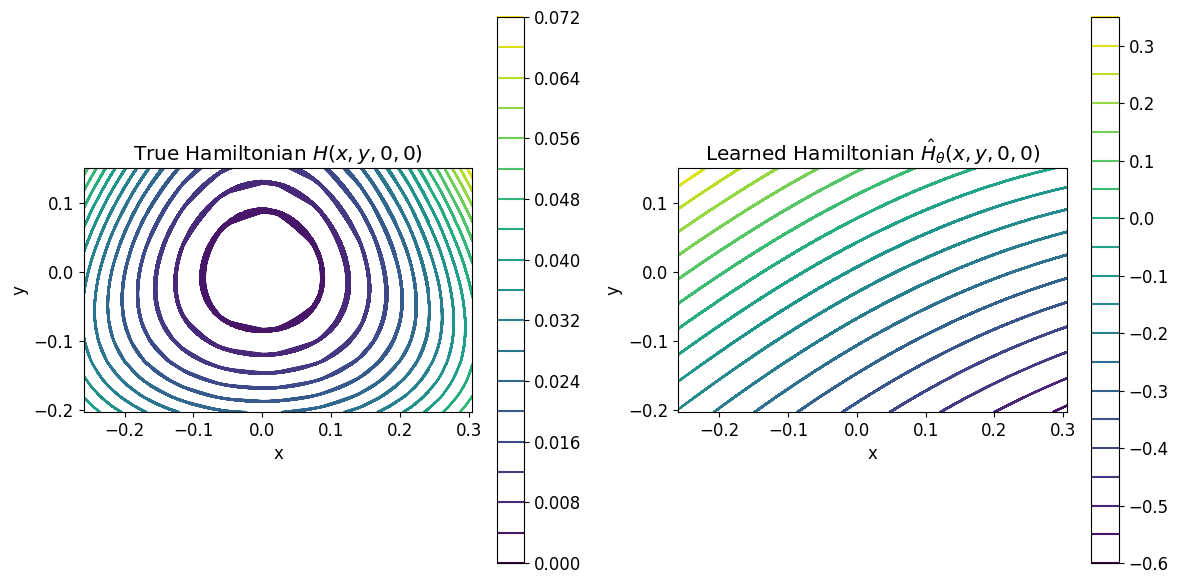

In [108]:
contour_plot_Hamiltonian(model_exp, sys, u_exact[0])

## Retraining with Fourier Basis

### Retraining Explicit Midpoint

tensor([0.3002, 0.3923, 0.4845, 0.5767, 0.6688, 0.7610, 0.8532, 0.9453, 1.0375,
        1.1297, 1.2218, 1.3140, 1.4062, 1.4983, 1.5905, 1.6827, 1.7748, 1.8670,
        1.9592, 2.0513, 2.1435, 2.2357, 2.3278, 2.4200, 2.5122, 2.6044, 2.6965,
        2.7887, 2.8809, 2.9730, 3.0652, 3.1574, 3.2495, 3.3417, 3.4339, 3.5260,
        3.6182, 3.7104, 3.8025, 3.8947, 3.9869, 4.0790, 4.1712, 4.2634, 4.3555,
        4.4477, 4.5399, 4.6320, 4.7242, 4.8164, 4.9085, 5.0007, 5.0929, 5.1851,
        5.2772, 5.3694, 5.4616, 5.5537, 5.6459, 5.7381, 5.8302, 5.9224, 6.0146,
        6.1067, 6.1989, 6.2911, 6.3832, 6.4754, 6.5676, 6.6597, 6.7519, 6.8441,
        6.9362, 7.0284, 7.1206, 7.2127, 7.3049, 7.3971, 7.4893, 7.5814, 7.6736,
        7.7658, 7.8579, 7.9501, 8.0423, 8.1344, 8.2266, 8.3188, 8.4109, 8.5031,
        8.5953, 8.6874, 8.7796, 8.8718, 8.9639, 9.0561, 9.1483, 9.2404, 9.3326,
        9.4248])


100%|██████████| 200/200 [5:15:31<00:00, 94.66s/it, epoch=199, loss=0.0126]  


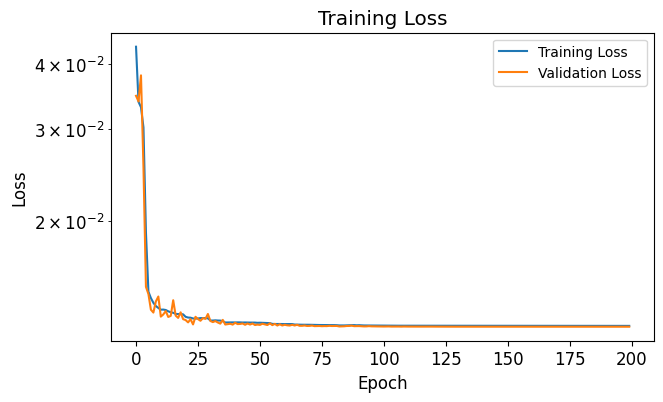

In [109]:
t = t_train
dt = t[1] - t[0]
T_max_train = t[-1].item()
min_a, max_a = 5 * dt, T_max_train / 2
#epochs = 200



candidates = torch.tensor(np.linspace(min_a, max_a, 100), dtype = torch.float32)
print(candidates)
t_vals = torch.tensor(np.linspace(0, T_max_train, int(nsamples_train)), dtype = torch.float32).unsqueeze(-1)

model_exp_fourier, new_training_details =Retrain_with_Forier_Basis(model_exp,candidates, integrator, train_data,t_vals, val_data,sys,lr, batch_size,epochs_Fourier,loss_func,penalty_func)


### Predicting Explicit Midpoint - New training

In [110]:
tmax = 12*np.pi
nsamples = int(100*tmax/12)
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp_fourier.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_exp[0].detach().numpy()

100%|██████████| 1/1 [00:00<00:00, 111.06it/s]

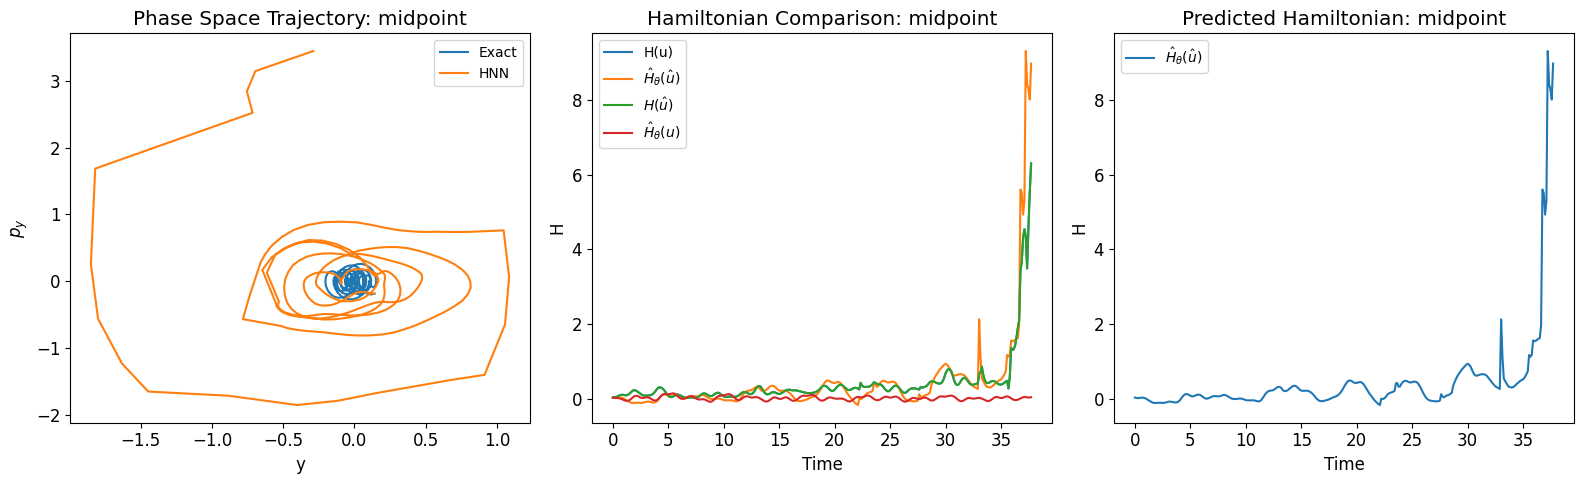

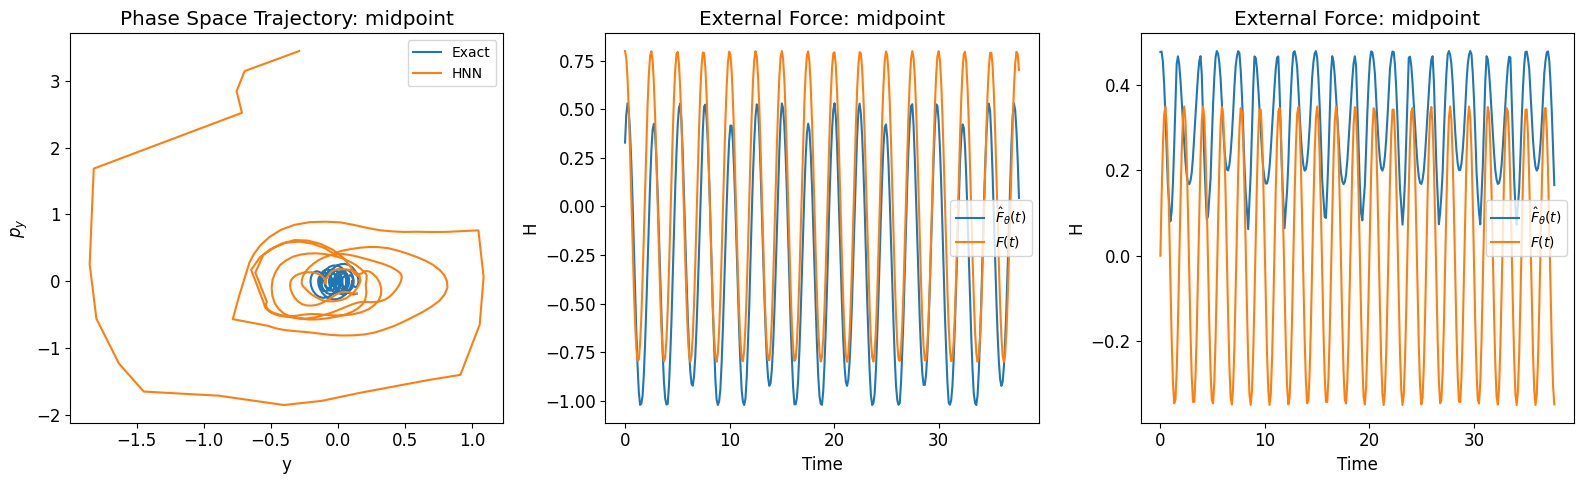

In [111]:
u0 = u0s
plot_PHNN_prediction(model_exp,u_pred,u_exact,t_sample,sys,u0,integrator)

In [112]:
true_diss = sys.get_dissipation()
true_diss

array([[-0.2 , -0.07]])

In [113]:
model_exp_fourier.Get_N()

Parameter containing:
tensor([[-0.5018,  0.1475]], requires_grad=True)

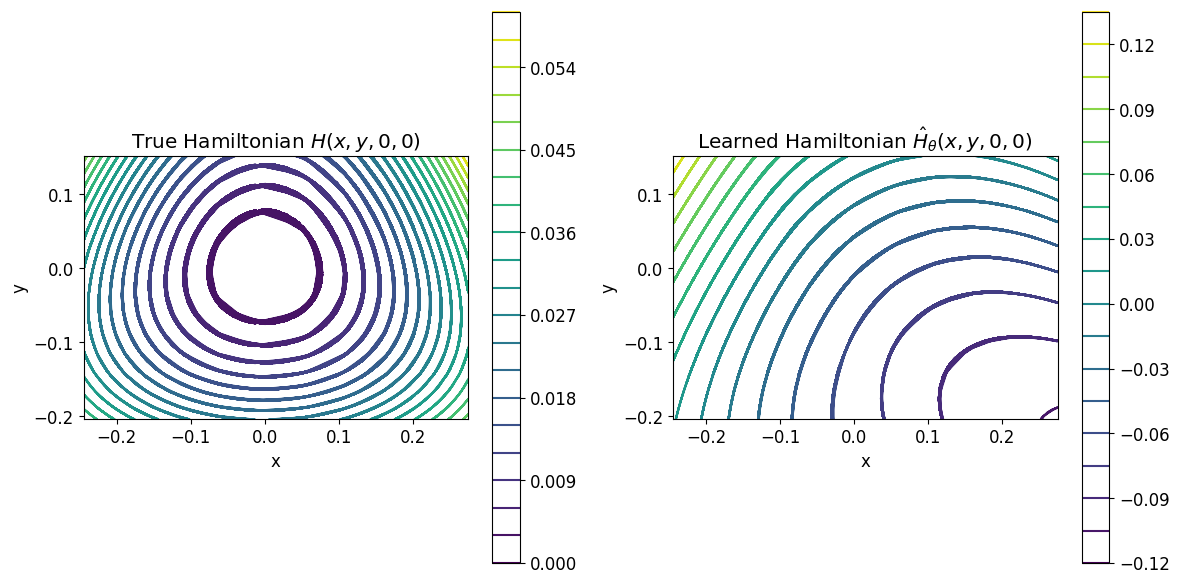

In [114]:
contour_plot_Hamiltonian(model_exp_fourier, sys, u_exact[0])

## Symplectic Midpoint 

In [115]:
T_max_train = 6*np.pi
nsamples_train = int(100*T_max_train/6)
#total_trajectories = 2000
ntraj_train = int(total_trajectories*0.7)
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = int(total_trajectories*0.3)
#epochs = 100



sys = HenonHeilesExternalForce()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [116]:
integrator = "symplectic midpoint"

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s =u0s_train)
train_data = (u_start, u_end,t_start, dt), dudt

(u_start, u_end,t_start, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator,u0s =u0s_val)
val_data = (u_start, u_end, t_start, dt), dudt

100%|██████████| 1200/1200 [01:15<00:00, 15.88it/s]


100%|██████████| 100/100 [1:51:24<00:00, 66.85s/it, epoch=99, loss=7.03e-5]


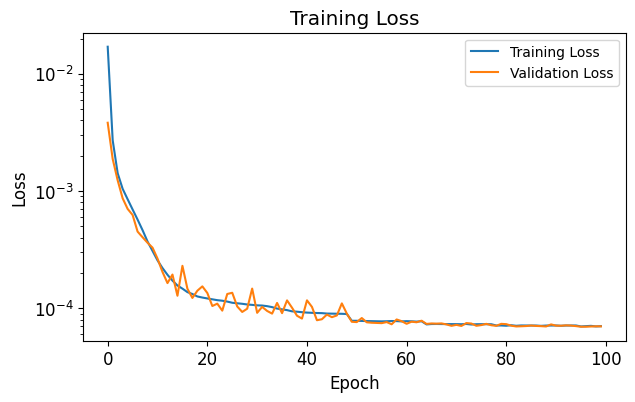

In [117]:
Hamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)
External_Forces_est = ExternalForceNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)


model_symp = PortHamiltonianNeuralNetwork(nstates = 4, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)


#optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)
optimizer_symp = torch.optim.AdamW(model_symp.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_symp, factor=0.5, patience=5)

trainer = Training(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp, system = sys, batch_size=batch_size,epochs = epochs)
model_symp, trainingdetails_symp = trainer.train(loss_func=loss_func,penalty_func = penalty_func,scheduler=scheduler)

### Predicting from Symplectic Midpoint - Training Interval

In [118]:
tmax = 6*np.pi
nsamples = int(100*tmax/6)
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_symp[0].detach().numpy()

100%|██████████| 1/1 [00:00<00:00, 10.78it/s]
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/NumericalIntegration/Numerical_Integration.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian

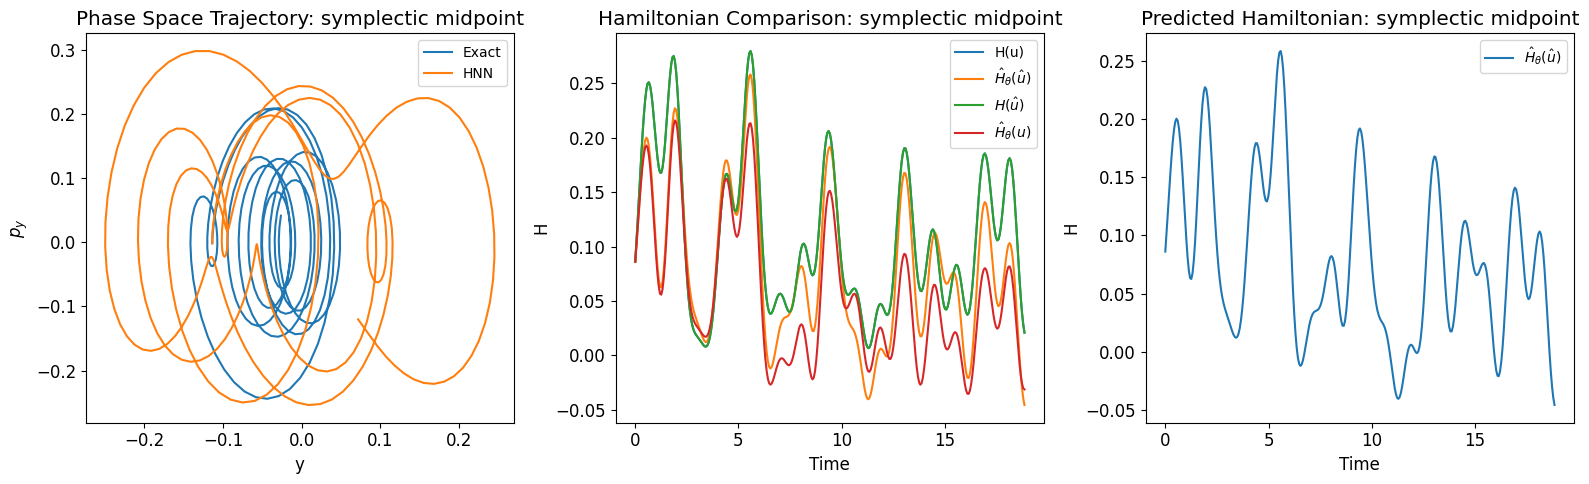

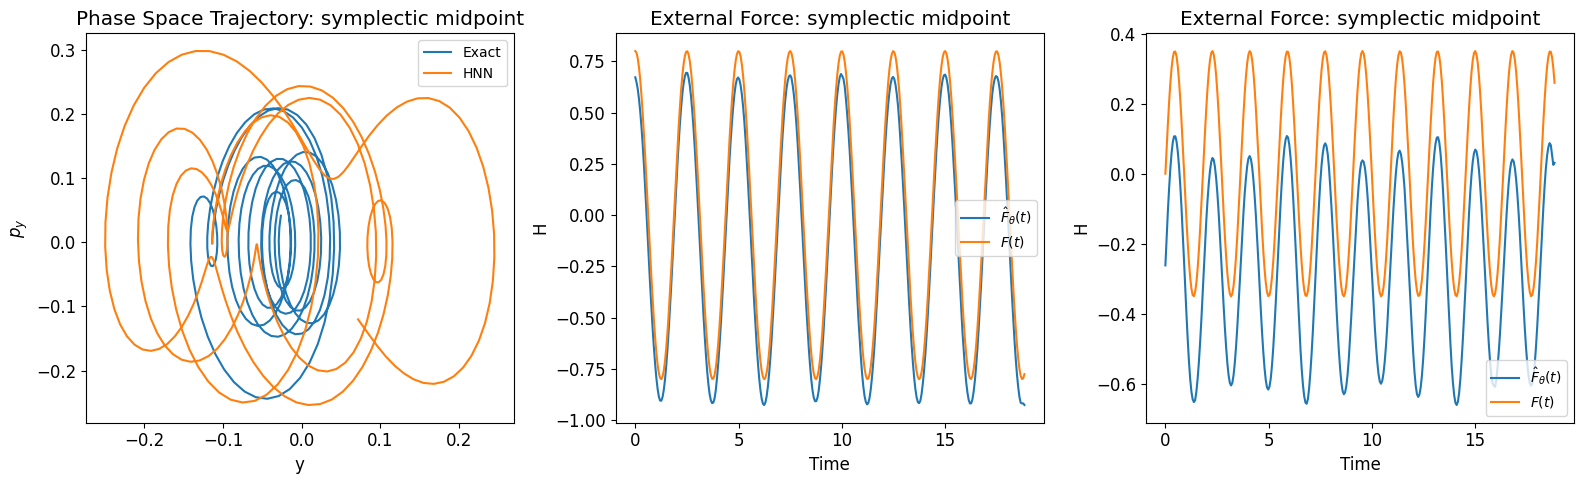

In [119]:
u0 = u0s
plot_PHNN_prediction(model_symp,u_pred,u_exact,t_sample,sys,u0,integrator)

Ser ut som den lærer riktig amplitude for External force men med et konstantledd feil, rart at dette skjer pga learning rate?

In [120]:
true_diss = sys.get_dissipation()
true_diss

array([[-0.2 , -0.07]])

In [121]:
model_symp.Get_N()

Parameter containing:
tensor([[-0.1026, -0.0321]], requires_grad=True)

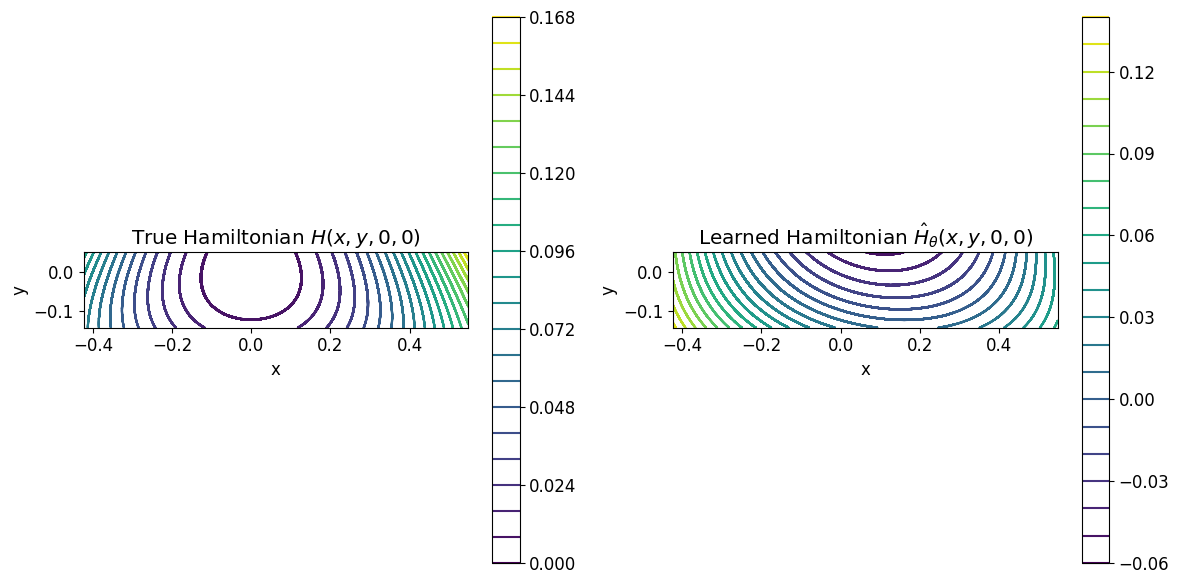

In [122]:
contour_plot_Hamiltonian(model_symp, sys, u_exact[0])

### Predicting from Symplectic Midpoint - Testing Interval

In [123]:
tmax = 12*np.pi
nsamples = int(100*tmax/12)
dt = tmax/nsamples


nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_symp[0].detach().numpy()

100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian

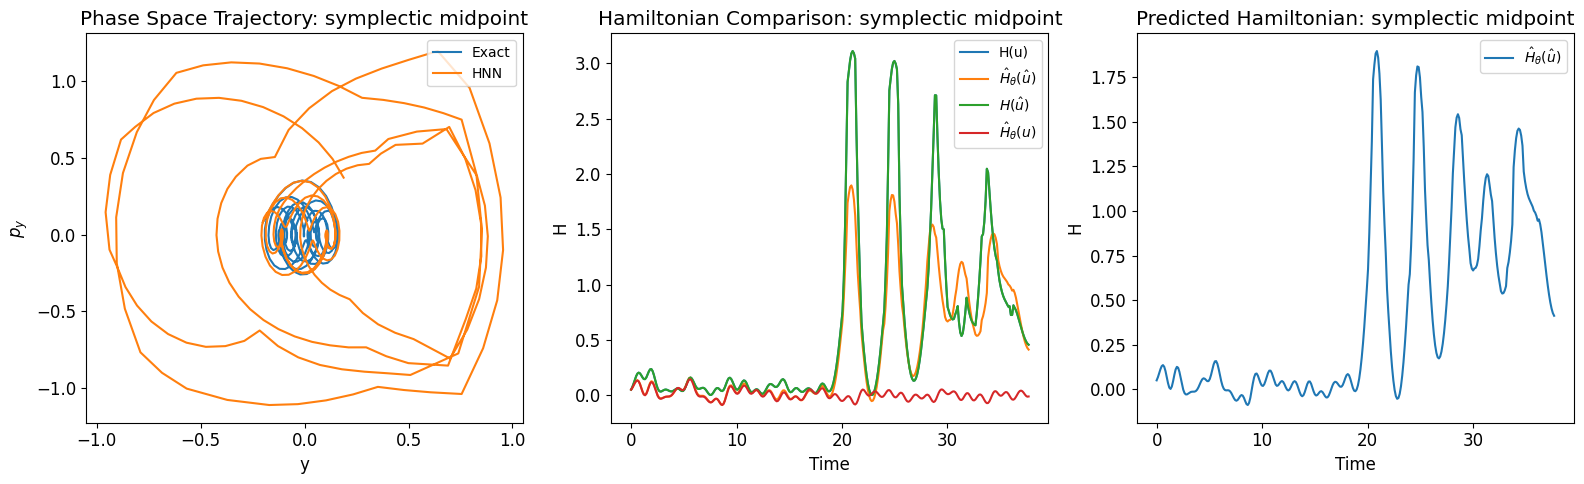

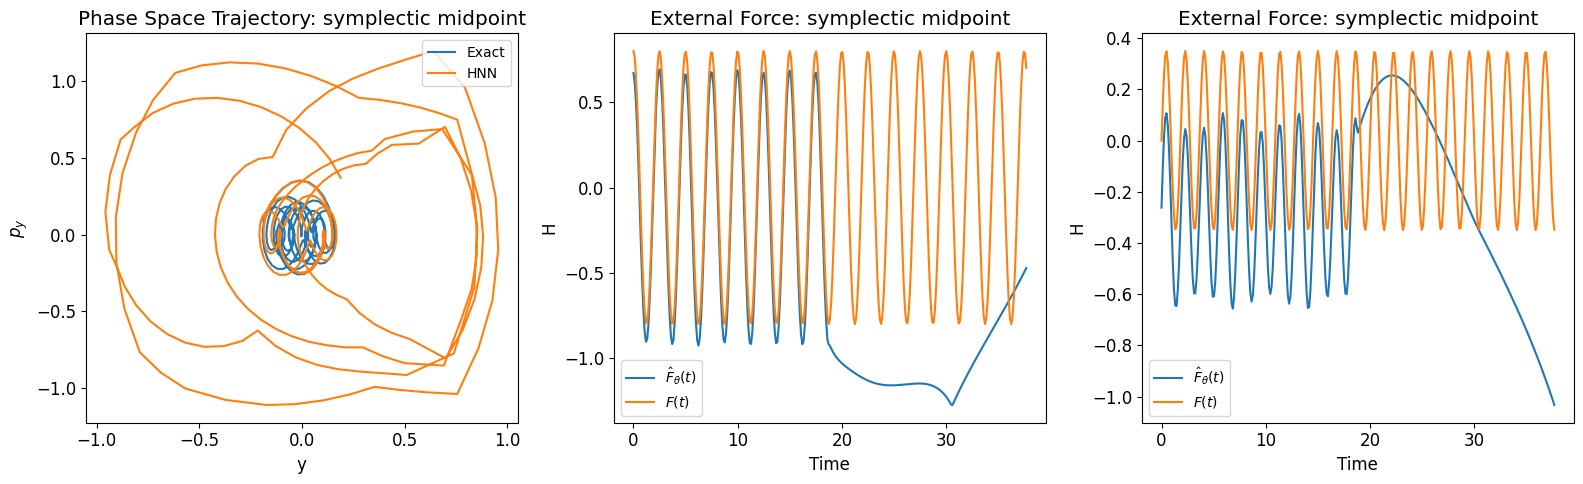

In [124]:
u0 = u0s
plot_PHNN_prediction(model_symp,u_pred,u_exact,t_sample,sys,u0,integrator)

In [125]:
true_diss = sys.get_dissipation()
true_diss

array([[-0.2 , -0.07]])

In [126]:
model_symp.Get_N()

Parameter containing:
tensor([[-0.1026, -0.0321]], requires_grad=True)

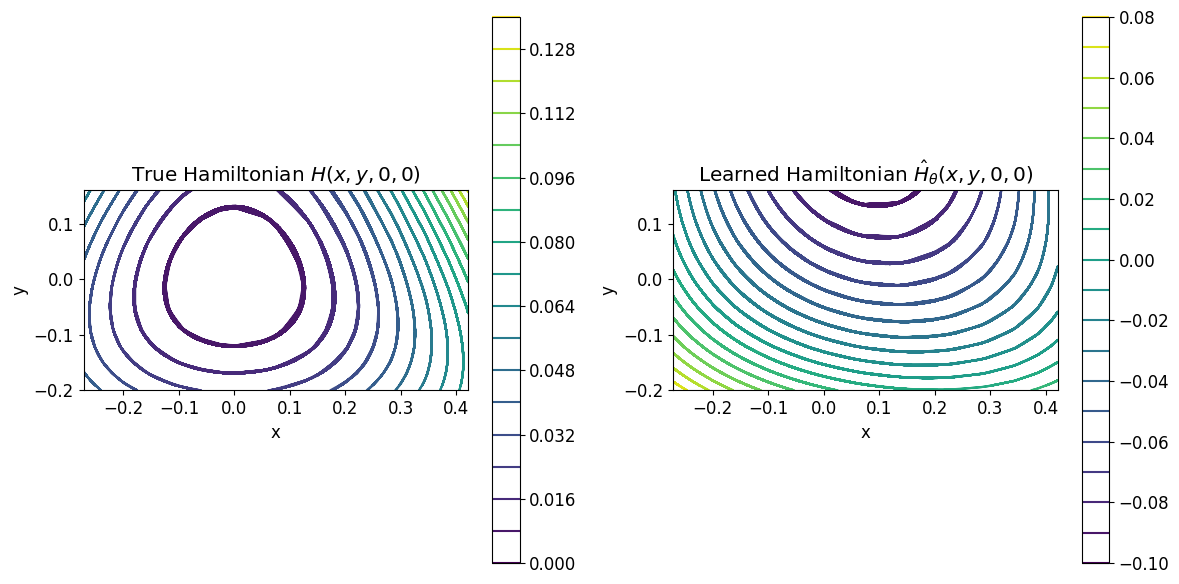

In [127]:
contour_plot_Hamiltonian(model_symp, sys, u_exact[0])

## Retraining with Fourier Basis

### Retraining Symplectic Midpoint

tensor([0.3002, 0.3923, 0.4845, 0.5767, 0.6688, 0.7610, 0.8532, 0.9453, 1.0375,
        1.1297, 1.2218, 1.3140, 1.4062, 1.4983, 1.5905, 1.6827, 1.7748, 1.8670,
        1.9592, 2.0513, 2.1435, 2.2357, 2.3278, 2.4200, 2.5122, 2.6044, 2.6965,
        2.7887, 2.8809, 2.9730, 3.0652, 3.1574, 3.2495, 3.3417, 3.4339, 3.5260,
        3.6182, 3.7104, 3.8025, 3.8947, 3.9869, 4.0790, 4.1712, 4.2634, 4.3555,
        4.4477, 4.5399, 4.6320, 4.7242, 4.8164, 4.9085, 5.0007, 5.0929, 5.1851,
        5.2772, 5.3694, 5.4616, 5.5537, 5.6459, 5.7381, 5.8302, 5.9224, 6.0146,
        6.1067, 6.1989, 6.2911, 6.3832, 6.4754, 6.5676, 6.6597, 6.7519, 6.8441,
        6.9362, 7.0284, 7.1206, 7.2127, 7.3049, 7.3971, 7.4893, 7.5814, 7.6736,
        7.7658, 7.8579, 7.9501, 8.0423, 8.1344, 8.2266, 8.3188, 8.4109, 8.5031,
        8.5953, 8.6874, 8.7796, 8.8718, 8.9639, 9.0561, 9.1483, 9.2404, 9.3326,
        9.4248])


100%|██████████| 200/200 [3:49:12<00:00, 68.76s/it, epoch=199, loss=0.00501]  


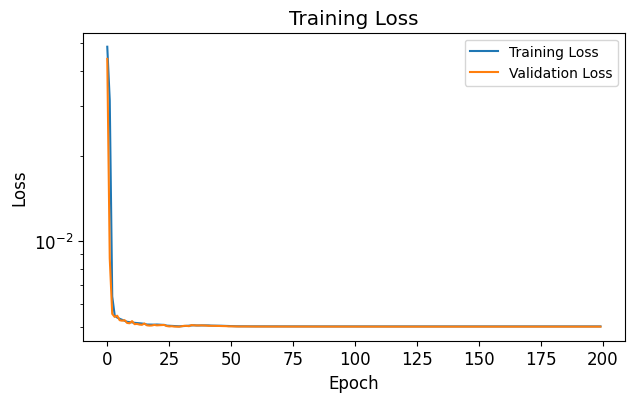

In [128]:
t = t_train
dt = t[1] - t[0]
T_max_train = t[-1].item()
min_a, max_a = 5 * dt, T_max_train / 2
#epochs = 200

candidates = torch.tensor(np.linspace(min_a, max_a, 100), dtype = torch.float32)
print(candidates)
t_vals = torch.tensor(np.linspace(0, T_max_train, int(nsamples_train)), dtype = torch.float32).unsqueeze(-1)

model_symp_fourier, new_training_details =Retrain_with_Forier_Basis(model_symp,candidates, integrator, train_data,t_vals, val_data,sys,lr, batch_size,epochs_Fourier,loss_func,penalty_func)


### Predicting Symplectic Midpoint - New training

In [129]:
tmax = 12*np.pi
nsamples = int(100*tmax/12)
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "symplectic midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp_fourier.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_symp[0].detach().numpy()

100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian

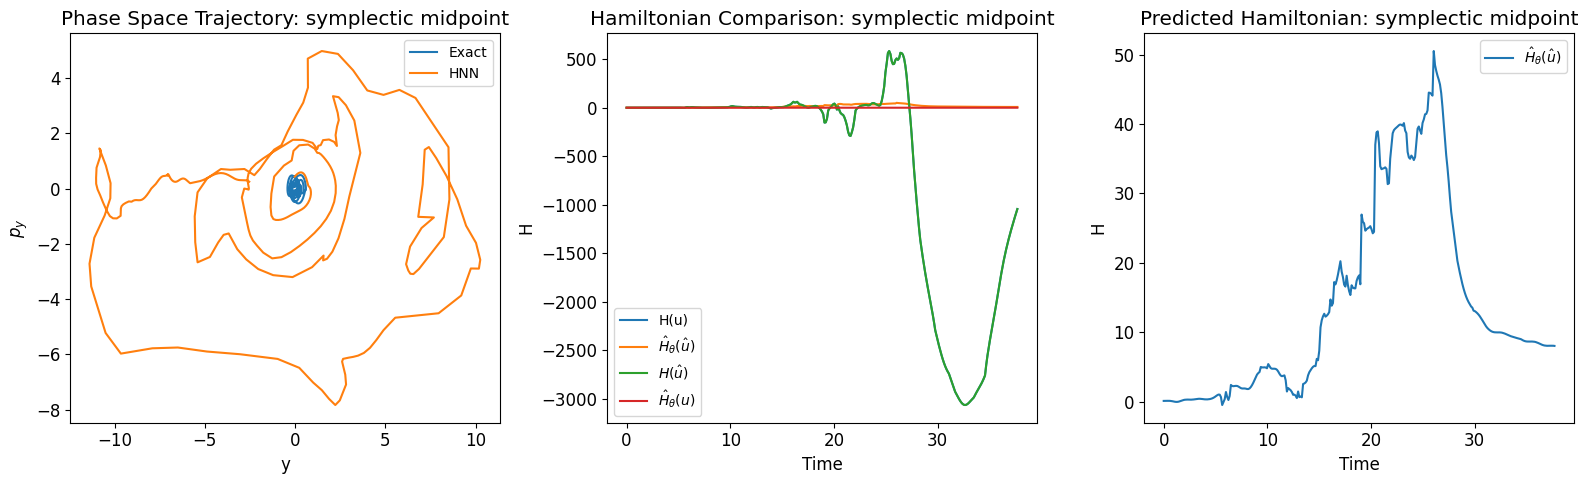

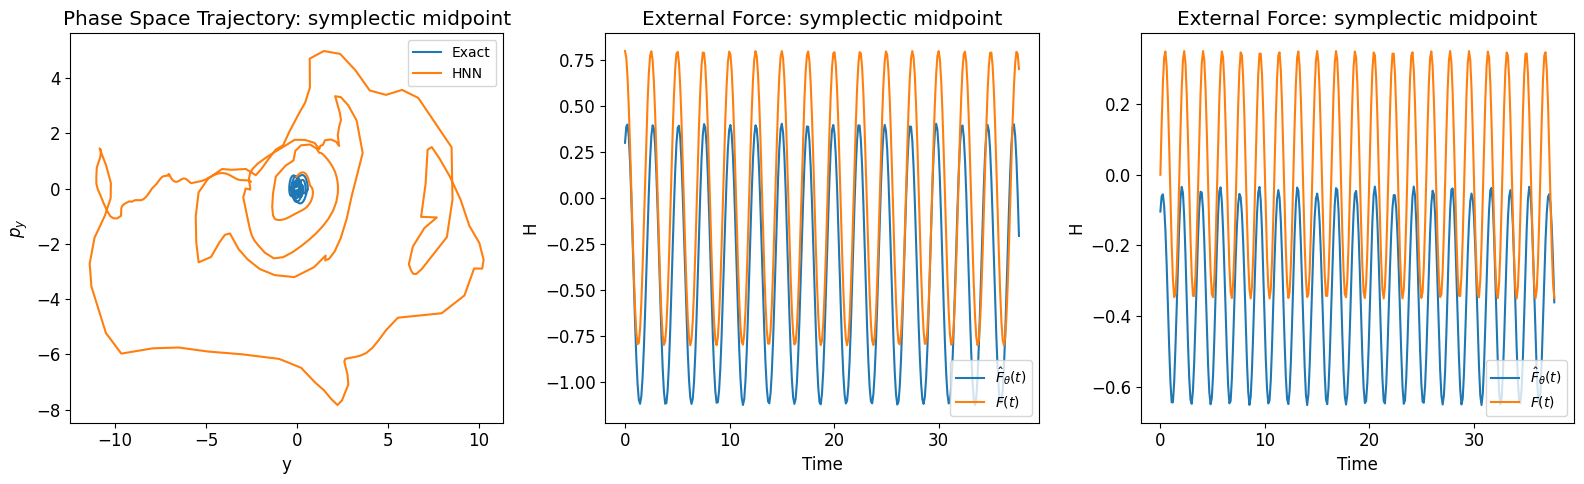

In [130]:
u0 = u0s
plot_PHNN_prediction(model_symp_fourier,u_pred,u_exact,t_sample,sys,u0,integrator)

In [131]:
true_diss = sys.get_dissipation()
true_diss

array([[-0.2 , -0.07]])

In [132]:
model_symp_fourier.Get_N()

Parameter containing:
tensor([[-0.2692,  0.0855]], requires_grad=True)

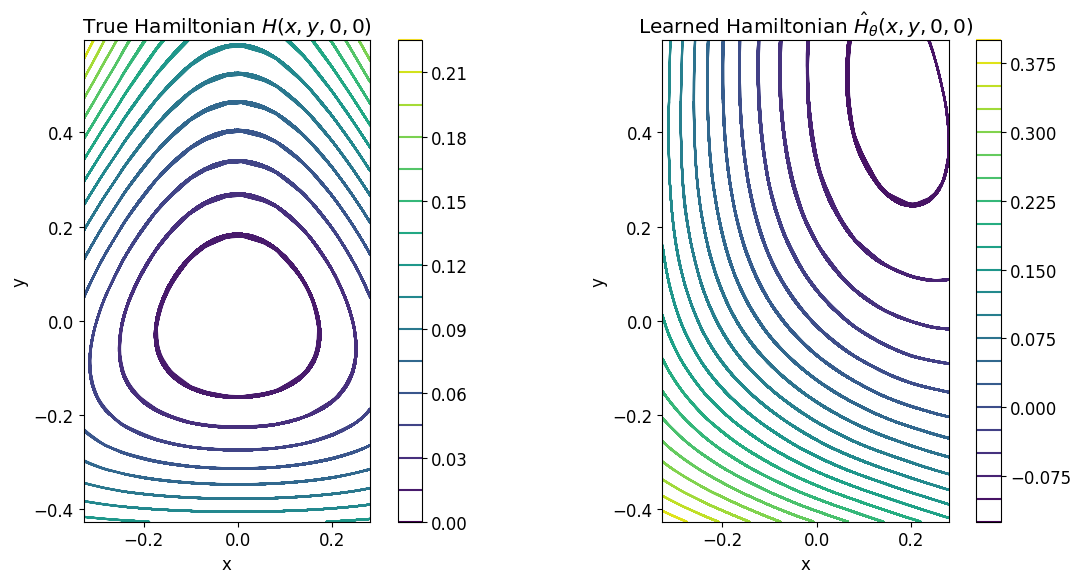

In [133]:
contour_plot_Hamiltonian(model_symp_fourier, sys, u_exact[0])

In [134]:
model_symp_fourier.Get_N()

Parameter containing:
tensor([[-0.2692,  0.0855]], requires_grad=True)

In [135]:
u =  u_exact[0][0]

dH = sys.Hamiltonian_grad(u.T).T

dissipation = np.zeros_like(u)
if dH.ndim ==1:
    dissipation[2] = - 0.1* dH[2]
    dissipation[3] = -0.05 * dH[3]
else:
    dissipation[:,2] = - 0.1* dH[:,2]
    dissipation[:,3] = -0.05 * dH[:,3]
print(dissipation)


[ 0.          0.         -0.00995783 -0.02153041]


In [136]:
C = model_symp_fourier.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - C) for u in u_exact.squeeze(0)])
H_nn_exact[0]

tensor(0.0981)

In [137]:
sys.Hamiltonian(u)

np.float64(0.09809803753377724)

In [138]:
external_force_exact = np.zeros_like(u)
external_force_exact[2] = 0.5 * np.cos(2 * np.pi * t)
external_force_exact[3] =  0.2 * np.sin(2 * np.pi * t)
external_force_exact

ValueError: setting an array element with a sequence.

In [ ]:
t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(-1) 
external_force = model_symp.External_Force(t_tensor).detach() 
external_force[0]

tensor([ 0.0784, -0.0031])